# TSSL Exam - 2021-02-17
This notebook contains the four exam problems.

* Please write your solutions directly in the notebook.

* Your submission should consist of: (i) an executable notebook (.ipynb file), **and** a pdf printout of the same notebook. Please make sure that all your answers are visible in the pdf file. To generate the pdf file from the notebook, you can either go to _File->Download as->PDF via LaTeX (.pdf)_, or go to _File->Print preview_ and "print" the web page as a pdf file.

* If relevant, hand-written calculations and drawings can be submitted alongside the notebook/pdf printout. Please scan/take a picture of your hand-written solutions and upload them in pdf, jpg or png format alongside the notebook. If you use this option, you need to **clearly mark in the notebook** that part of the solution is attached as a separate file and provide a reference to that file.  

* Apart from the exception mentioned above, the notebook should be self-contained and executable. Standard packages and the `tssltools` module that is **distributed along with the exam** may be imported. This module contains **all the auxiliary code that you have used in the labs**, i.e. from the `tssltools_lab#` files, regardless of whether or not these functions/classes are relevant for solving the exam. The `tssltools` module also contains some additional code that can come in handy (in that case, the relevant code is referred to in the problem formulation).
If you rely on external code that you have written (e.g. when solving the lab assignments in the course) it should be copied in to the notebook.

* **Responsible teacher:** Fredrik Lindsten, available over email (fredrik.lindsten@liu.se) or phone (070 085 07 90) during the exam.  


### Grades
The maximum number of points is 40 (8+13+12+7 for the four problems, respectively). The _tentative_ levels for the grades (A-F) are:
- A=37-40 points
- B=33-36 points
- C=23-32 points
- D=19-22 points
- E=15-18 points
- F=0-14 points (fail)

In [71]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# Default figure size for plots.
# Feel free to change this if the suggested setting results in too small/large plots on your machine!
plt.rcParams["figure.figsize"] = (10,6)

## Problem 1:
(9 points)

**a)** The file `data_problem1.csv` contains a sequence of observations. In this problem you should do the following:

1. Load the data and split it into 80 % training and 20 % validation data.
2. Pre-process the data as you find appropriate.
3. Produce mean-squared-error curves for model orders in the range $p=1,\dots,10$. Plot both training and validation errors as two separate curves.
4. Based on the error curves, pick a final model order $p$ that you think is appropriate. Motivate your choice!

_Hint:_ You can use the functions `fit_ar` and `predict_ar_1step` from lab 1 (also available in `tssltools`).  

<div style="text-align: right"> (6p) </div>


In [73]:
data=pandas.read_csv('data_problem1.csv',header=0)
y0 = data['Data'].values

**Solution:**

In [74]:
from tssltools import fit_ar, predict_ar_1step
from sklearn import linear_model as lm  # Used for solving linear regression problems

1. First we split into train/test

In [75]:
ndata = len(y0)
ntrain = int(ndata*0.8)
ntest = ndata-ntrain

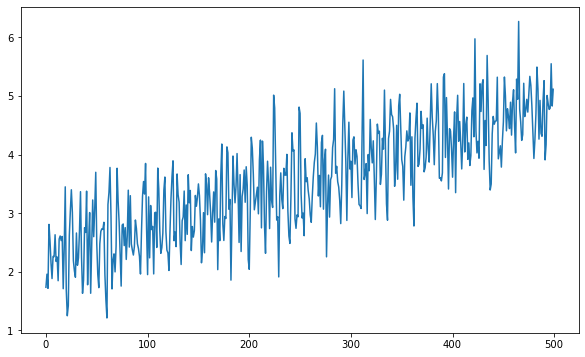

In [76]:
plt.plot(y0)

2. The data appears to have a growing trend. We use a linear detrend. 

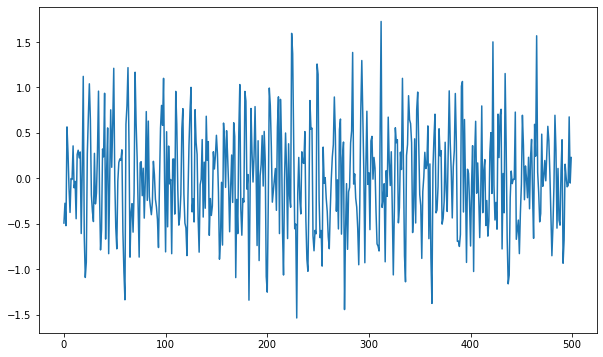

In [77]:
# Linear regression input u(t)=t
u = np.arange(ndata)[:,np.newaxis]   # lm.fit Requires 2D input

# Fit a linear regression
regr = lm.LinearRegression(fit_intercept=True) # With fit_intercept=True we get an intercept term without including it in the feature vector
regr.fit(u[:ntrain,:],y0[:ntrain])

# Predict
ypred_lm = regr.predict(u)

# Plot difference
plt.plot(y0 - ypred_lm)

In [78]:
y = y0-ypred_lm
ytrain = y[:ntrain]

*It looks stationary so we are happy with this detrending!*

3. We run a loop over all model orders and compute the errors

In [79]:
help(predict_ar_1step)

Help on function predict_ar_1step in module tssltools:

predict_ar_1step(theta, y_target)
    Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.
    
    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n)



Run a train-validation data loop.

In [80]:
num_orders = 10
mse_val = np.zeros(num_orders)
mse_train = np.zeros(num_orders)
orders = range(1,num_orders+1)

for p in orders:
    th = fit_ar(ytrain, p)
    y_pred = predict_ar_1step(th, y)    
    mse_val[p-1] = np.mean( (y[ntrain:] - y_pred[ntrain-p:])** 2) # We skip the ntrain-p first elements, corresponding to training data
    mse_train[p-1] = np.mean( (y[p:ntrain] - y_pred[:ntrain-p])** 2)

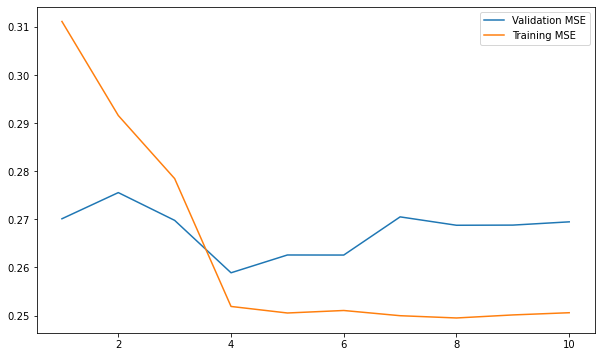

In [81]:
plt.plot(orders, mse_val)
plt.plot(orders, mse_train)
plt.legend(['Validation MSE','Training MSE'])


4. We see that both curves agree that $p=4$ seems to be a good choice. We have a "knee" in the training curve and a minimum in the validation curve.

In [82]:
p = np.argmin(mse_val)+1
print(p)

4


In [83]:
# Refit the model on the chosen order
th = fit_ar(ytrain, p)
print(th)

[ 0.20923929 -0.24467069 -0.12415164 -0.30890155]


___

**b)** Verify that the resulting AR model is stable _directly based on the model parameters_ (i.e. you should not simulate the model for the verification).

_Hint:_ You can use `np.linalg.eigvals` to solve this problem.

<div style="text-align: right"> (3p) </div>

**Solution**

In [84]:
# We write the AR model on state space form
A = np.zeros((p,p))
A[0,:] = th
A[1:, 0:-1] = np.identity(p-1)

# Compute eigenvalues of the A-matrix
ll = np.linalg.eigvals(A)
# The absolute values will tell us whether the eigenvalues are all within the unit circle or not
np.abs(ll)


array([0.83554779, 0.83554779, 0.66517933, 0.66517933])

All eigenvalues are within the unit circle => stable!

## Problem 2:
(12 points)

**a)** In this problem we will study a **structural time series** model.
$$
    \begin{cases} \alpha_t = T \alpha_{t-1} + R \eta_t, & \eta_t \sim \mathcal{N}(0,Q), \\ y_t = Z \alpha_t + \varepsilon_t, & \varepsilon_t \sim \mathcal{N}(0,H), \end{cases}
$$
where $\alpha_t$ contains a trend and seasonal part.
The trend in this model is **quadratic** but the seasonality is unknown.

The data file `data_problem2.csv` contains a sequence of observations from this model. Using this data you are tasked to do the following:

1. Look at the provided data and find the seasonality $s$.
2. Setup the complete model by writing down the matrices $T$, $R$, $Q$, $Z$, and $H$. Also specify your hidden states $\alpha_t$. Remember to motivate your choices of matrices.
3. Implement the Kalman filter and run it on the data to find the trend and seasonal component. Let the observation variance be 1. Set the seasonal and trend variance in the model to $0.01^2$. Set the mean of the initial state to 0 and the initial variance to the identity matrix multiplied by 10.
4. Plot the resulting seasonal and trend component from the kalman filter.

_Hint:_ The `LGSS` and `kfs_res` classes used in Lab 2 are available in the `tssltools` module.

<div style="text-align: right"> (9p) </div>

**Solution**

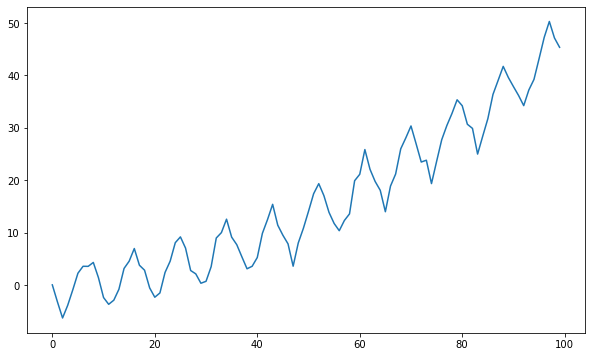

In [85]:
data=pandas.read_csv('data_problem2.csv',header=0)
y2 = data['Data'].values
plt.plot(y2)

1. Look at the provided data and find the seasonality $s$.

Looking at the data we find 11 repetitions over 100 observations, $\tfrac{100}{11} \approx 9 = s$.

2. Set up the model matrices according to the model definition in the problem formulation and define the state vector.

The trend was quadratic, so we need $k = 3$ in the trend component of the structural time series. Using the formulas from the lectures we have
\begin{align*}
        T_{\mu} = \begin{pmatrix}
            3 & -3 & 1 \\
            1 & 0 & 0 \\
            0 & 1 & 0
        \end{pmatrix} \quad
        R_{\mu} = \begin{pmatrix}
            1 \\
            0 \\
            0
        \end{pmatrix} \quad
        Z_{\mu} = \begin{pmatrix}
        1 & 0 & 0
        \end{pmatrix}
\end{align*}
with $s=9$ we have the following seasonal matrices
\begin{align*}
    T_{\gamma} = \begin{pmatrix}
        \mathbf{-1}^\top & -1 \\
        \mathbf{I} & \mathbf{0}
    \end{pmatrix} \quad 
    R_{\gamma} = \begin{pmatrix}
        1 \\
        \mathbf{0}
    \end{pmatrix} \quad
    Z_{\gamma} = \begin{pmatrix}
        1 & \mathbf{0}^\top
    \end{pmatrix}
\end{align*}
where the bold submatrices are column matrices of length $s-2 = 7$ and $\mathbf{I}$ is the identity matrix of size $s-2=7$.

The noise term $Q$ is given by

$$ Q =  \begin{pmatrix}
        \sigma^{2}_{\mu} & 0 \\
        0 & \sigma^{2}_{\gamma}
    \end{pmatrix} $$

We also have the state $\alpha_t = (\mu_t, \mu_{t-1}, \mu_{t-2}, \gamma_{t}, \ldots, \gamma_{t-7})^{\top}$ and $H = \sigma^2_{\varepsilon}$.

In [86]:
from tssltools import LGSS, kfs_res


################# delta = 0.2 ????
################# sigma2_eta = .1
sigma2_eta = .01**2
sigma2_eps = 1.

# 1. From derivation above
Ttrend = np.array([[3,-3,1],[1,0,0],[0,1,0]])
Rtrend = np.zeros((3,1))
Rtrend[0,0] = 1
Ztrend = np.zeros((1,3))
Ztrend[0,0] = 1

s = 9
T11 = -1*np.ones((1,s-2))
T12 = -1*np.ones((1,1))
T21 = np.eye(s-2)
T22 = np.zeros((s-2,1))
Tseason = np.block([[T11, T12], [T21, T22]])
Rseason = np.zeros((8,1))
Rseason[0,0] = 1
Zseason = np.zeros((1,8))
Zseason[0,0] = 1

from scipy.linalg import block_diag
T = block_diag(Ttrend, Tseason)
R = block_diag(Rtrend, Rseason)
Z = np.concatenate( (Ztrend, Zseason), axis=1)
print(T.shape)
print(R.shape)
print(Z.shape)
################# Q = np.array([[0.05, 0],[0, 0.05]])
Q = np.array([[sigma2_eta, 0],[0, sigma2_eta]])

################# sigma2_eps = 1. Defined above

(11, 11)
(11, 2)
(1, 11)


In [87]:
# Initial state
a1 = np.zeros(11)
P1 = 10.*np.eye(11)

model = LGSS(T, R, Q, Z, sigma2_eps, a1, P1)

help(model.get_params)

# 3. Kalman filter implementation
def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d  # State dimension
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)
    F_pred = np.zeros(n)

    T, R, Q, Z, H, a1, P1 = model.get_params()  # Get all model parameters (for brevity)

    for t in range(n):
        # Time update (predict)
        if t == 0:  # Initialize predictions
            alpha_pred[:, 0, 0] = a1  # a1 is a (d,) array
            P_pred[:, :, 0] = P1
        else:
            alpha_pred[:, :, t] = T @ alpha_filt[:, :, t - 1]
            P_pred[:, :, t] = T @ P_filt[:, :, t - 1] @ T.T + R @ Q @ R.T

        # Compute prediction of current output
        y_pred[t] = Z @ alpha_pred[:, :, t]
        F_pred[t] = Z @ P_pred[:, :, t] @ Z.T + H

        # Measurement update (correct)
        if np.isnan(y[t]):  # Handle missing data
            alpha_filt[:, :, t] = alpha_pred[:, :, t].copy()
            P_filt[:, :, t] = P_pred[:, :, t].copy()
        else:
            K = P_pred[:, :, t] @ Z.T / F_pred[t]
            alpha_filt[:, :, t] = alpha_pred[:, :, t] + K * (y[t] - y_pred[t])
            """Here there is a notational benefit from working with (d,1,n) arrays instead of (d,n) arrays. K is (d,1)
            and so is alpha_pred[:,:,t]. If we would instead have alpha_pred[:,t] with alpha_pred being (d,n) we would
            get (d,) + (d,1) which is (insanely!) broadcasted to (d,d)."""
            P_filt[:, :, t] = (np.identity(d) - K @ Z) @ P_pred[:, :, t]

    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf



Help on method get_params in module tssltools:

get_params() method of tssltools.LGSS instance
    Return all model parameters.
    
    T, R, Q, Z, H, a1, P1 = model.get_params()



In [88]:
kf = kalman_filter(y2,model)

4. Plot the filtered position (which is the first element of the state vector)

Text(0, 0.5, 'x_t')

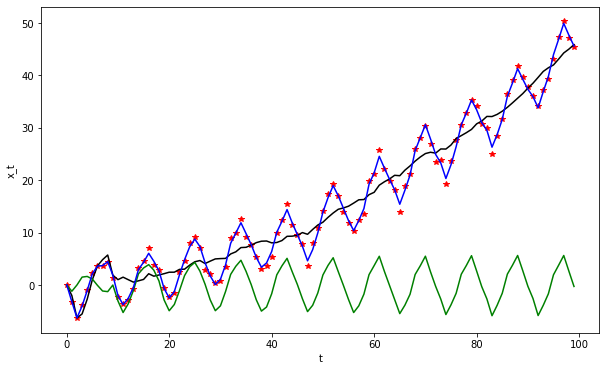

In [89]:
plt.figure()
plt.plot(y2,'r*')
plt.plot(kf.alpha_filt[0,0,:],'k')
plt.plot(kf.alpha_filt[3,0,:],'g')
plt.plot(kf.alpha_filt[0,0,:] + kf.alpha_filt[3,0,:],'b')
plt.xlabel('t')
plt.ylabel('x_t')

___

**b)** Often we are in the situation of missing data. In this task you will study the difference between the smoothing and filtering distributions when working with missing data. You should do the following:

1. Remove the data between index 20 and 60 from the data by setting those values to `np.nan`
2. Run the Kalman filter on this new data.
3. Run the Kalman smoother on the same data. The algorithm `kalman_smoother` is provided in `tssltools`
4. Plot the data, the filtered mean $Z \hat\alpha_{t|t}$ and and the smooted mean $Z \hat\alpha_{t|n}$ in the same figure.
5. Comment on the results

<div style="text-align: right"> (3p) </div>

**Solution**

In [90]:
from tssltools import kalman_smoother

# 1. Make a copy of the data and remove the missing observations
y2withNan = y2.copy()
y2withNan[20:60] = np.nan    #### Could also be 19:60, or 20:61 depending on how one reads the question

# 2-3. Run the KF+KS
kf = kalman_filter(y2withNan, model)
ks = kalman_smoother(y2withNan, model, kf)

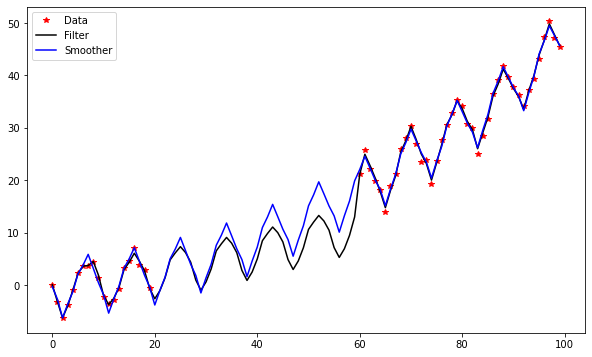

In [91]:
# 4. Plot
plt.figure()
plt.plot(y2withNan,'r*')
plt.plot(kf.alpha_filt[0,0,:] + kf.alpha_filt[3,0,:],'k')
plt.plot(ks.alpha_sm[0,0,:] + ks.alpha_sm[3,0,:],'b')
plt.legend(['Data','Filter','Smoother'])

___

## Problem 3:
(10 points)

The file `data_problem3.csv` contains a sequence of observations. We will model this sequence using the following non-linear state space model,
$$
    \begin{cases} \alpha_{t+1} = 2 \sin(\alpha_{t}) + \sigma_{\eta} \eta_t, & \eta_t \sim \mathcal{N}(0,1) \\
    y_t = \frac{\alpha_t^2}{2} + \sigma_{\varepsilon} \varepsilon_t & \varepsilon_t \sim \mathcal{N}(0,1).
    \end{cases}
$$
with initial distribution $\alpha_1 \sim \mathcal{N}(0,\sigma_{\eta}^{2})$.

**a)** To implement a bootstrap particle filter we need to perform three operations, propagation, weighting, and resampling. In this problem you should do the following:

1. Find the conditional distribution of $y_t \mid \alpha_t$.
2. Implement a function that takes $N$ particles $\alpha_t^i$ and propagates them to $\alpha_{t+1}^i$.
3. Implement a function that takes $N$ particles $\alpha_t^i$ and an observation $y_t$ and calculates the log-weights $\log \omega_t^i$.

<div style="text-align: right"> (5p) </div>

**Solution:**

1. Conditioning on $\alpha_t$ means that we can view the first term in the observation equation as a constant mean. With additive Gaussian noise (second term of the equations), we get

\begin{align*}
    p(y_t | \alpha_t) = \mathcal{N}\left(y_t | \frac{\alpha_t^2}{2}, \sigma_{\varepsilon}^2\right).
\end{align*}

In [92]:
# 2. Propagation function
# We sample new particles from the transition/state update equation conditionally on the current particles
def propagate(particles, sigma_eta):
    N = len(particles)
    new_particles = 2 * np.sin(particles) +  sigma_eta*np.random.randn(N)
    return new_particles

# 3. Log-weight computation
# The log-weights are given by the log-pdf from part 1, evaluated at all particles
def logweight_fun(particles, y, sigma_eps):
    logweights = - 1/2 * ( y - particles**2/2 )**2 / (sigma_eps**2)
    return logweights

----

**b)** using the functions from the previous part implement a **Bootstrap Particle Filter** that runs on the data. You should solve the following parts:

1. Set the parameters $\sigma_{\eta} = 0.3$ and $\sigma_{\varepsilon} = 0.5$
2. Use the bootstrap particle filter to calculate the filtered mean of $\sin(\alpha_t)^2$. _(Note the square)_
3. Provide a plot of your estimate.

Use $N = 200$ particles when performing your estimate.

If you failed to do the first part you can use the functions `propagate_wrong` and `logweight_fun_wrong` from the `tssltools` module to implement and run your bootstrap particle filter.

<div style="text-align: right"> (5p) </div>

**Solution:**

In [93]:
# Helper function

def exp_norm(logW):
    const = np.max(logW)
    W = np.exp(logW - const)
    sumofweights = np.sum(W)
    logZ = np.log(sumofweights) + const
    W = W / sumofweights
    return W, logZ

In [94]:
#from tssltools import propagate_wrong, logweight_fun_wrong

############### par = np.array([1,.5]) # 1. State and observation noise
par = np.array([.3, .5]) # 1. State and observation noise standard deviation
N = 200

# 2. Particle filter implementation
def bpf(y, N, par):
    n = len(y)
    particles = np.zeros((n,N))
    logWeights = np.zeros((n,N))
    weights = np.zeros((n,N))
    
    estMean = np.zeros(n)
    estSquare = np.zeros(n)
    
    ######### particles[0,:] = 2 + par[0]*np.random.randn(N)
    particles[0,:] = par[0]*np.random.randn(N)
    logWeights[0,:] = logweight_fun(particles[0,:], y[0], par[1])
    weights[0,:],_ = exp_norm(logWeights[0,:])
    
    estMean[0] = np.sum(weights[0,:]*particles[0,:])
    estSquare[0] = np.sum(weights[0,:] * particles[0,:]**2)
    
    for t in range(1,n):
        # RESAMPLE
        ind = np.random.choice(N,N,True,p=weights[t-1,:])
        
        # PROPAGATE
        particles[t,:] = propagate(particles[t-1,ind], par[0])
        
        # WEIGHTING
        logWeights[t,:] = logweight_fun(particles[t,:], y[t], par[1])
        weights[t,:], _ = exp_norm(logWeights[t,:])
        
        # ESTIMATES
        estMean[t] = np.sum(weights[t,:] * np.sin(particles[t,:])**2)
    
    return estMean
    

In [95]:
# ...load the data
data=pandas.read_csv('data_problem3.csv',header=0)
y3 = data['Data'].values

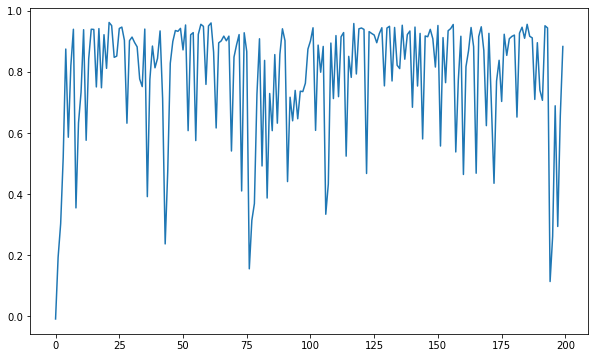

In [96]:
# ... Run the PF
est = bpf(y3,N,par)

# 3. We compute the variance estimate and plot the result
plt.figure()
plt.plot(est)

## Problem 4:
(9 points)

**a)** Consider the problem of one-step-ahead prediction for a time series $\{y_t\}_{t\geq 1}$. The code cell below defines a two-layer Jordan-Elman RNN for solving this problem. Write out the mathematical expressions corresponding to this model, in terms of the hidden state variables, the state update equations, and the output equations. Also, for all parameters in your model, specify their respective dimensions.

<div style="text-align: right"> (4p) </div>


In [97]:
from tensorflow import keras
from tensorflow.keras import layers

model=keras.Sequential([
    layers.SimpleRNN(units = 30, input_shape=(None,1), return_sequences=True, activation='tanh'),
    layers.SimpleRNN(units = 20, input_shape=(None,1), return_sequences=True, activation='tanh'),
    layers.Dense(units = 100, activation='relu'),
    layers.Dense(units = 1, activation='linear')
])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 30)          960       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 20)          1020      
_________________________________________________________________
dense_2 (Dense)              (None, None, 100)         2100      
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           101       
Total params: 4,181
Trainable params: 4,181
Non-trainable params: 0
_________________________________________________________________


**Solution**

The equations defining the model are

\begin{align*}
	\mathbf{h}^{(1)}_{t} &= \sigma( W^{(1)}\mathbf{h}^{(1)}_{t-1} + U^{(1)} y_{t-1} + b^{(1)} ), \\
    \mathbf{h}^{(2)}_{t} &= \sigma( W^{(2)}\mathbf{h}^{(2)}_{t-1} + U^{(2)} \mathbf{h}^{(1)}_{t-1} + b^{(2)} ), \\
	\hat y_{t|t-1} &= C \times \mathrm{ReLU}(W^{(3)} \mathbf{h_t}^{(2)} + b^{(3)}) + c,
\end{align*}

and the parameters are:

### RNN Layer 1:

* $W^{(1)}$ of size $30\times 30 = 900$
* $U^{(1)}$ of size $30 \times 1 = 30$
* $b^{(1)}$ of size $30 \times 1 = 30$

Total: 960

### RNN Layer 2:
* $W^{(2)}$ of size $20\times 20 = 400$
* $U^{(2)}$ of size $20 \times 30 = 600$
* $b^{(2)}$ of size $20 \times 1 = 20$

Total: 1020

### Dense Layer

* $W^{(3)}$ of size $100\times 20 = 2000$
* $b^{(3)}$ of size $100 \times 1 = 100$

Total: 2100

### Output Layer

* $C$ of size $1 \times 100 = 100$
* $c$ of size $1 \times 1 = 1$

Total: 101

___

**b)** Together with your collaborator you face the problem of fitting an RNN model for an observed time series consisting of 50,000 observations, $\{y_t\}_{t=1}^{50000}$. For computational reasons, your collaborator has concluded that you can only afford to process 100 observations per gradient update when training the model. The following generator function has been written for this purpose, which will be passed to the Keras training procedure (`model.fit`).

In [99]:
def generator_train(window_size=100):    
    # ntrain = number of training data points
    while True:        
        start_of_window = np.random.randint(0, ntrain - window_size)  # First time index of window (inclusive)
        end_of_window = start_of_window + window_size  # Last time index of window (exclusive, i.e. this is really the first index _after_ the window)
        yield x_train[:,start_of_window:end_of_window,:], y_train[:,start_of_window:end_of_window,:]

Explain what the the generator function does, either using words or a mathematical expression.

<div style="text-align: right"> (1p) </div>


**Solution**

Is picks out a window of `window_size` consecutive time points and returns the inputs and outputs for this window. The location of the window is sampled uniformly at random within the full training data sequence.

___

**c)** Continuing the question from part b). When evaluating the fitted model you are not very happy with the results. After careful investigations you conclude that there are very long ranging dependencies in this time seris, much longer than 100 time steps. You collaborator mentions that _stateful training_ might be a good idea in such situations, but can't remember exactly what it means. Explain (using a couple of sentences) what stateful training is and how/why it can be useful in this situation.

<div style="text-align: right"> (2p) </div>




**Solution**

Without stateful training the initial state of the RNN cells will be set to a default value at the start of each window. This means that we cannot capture temporal dependencies that are longer than the size of the window. With stateful training the RNN state is retained across iterations. Specifically, the final state after processing the first window of observations is used as initial state when processing the second window of observations, and so on.

___

**d)** Continuing the question from part c). Is there a problem with using stateful training (i.e. simply setting `stateful=True` in the RNN model definition) when using the generator from part a)? Explain briefly why/why not.

<div style="text-align: right"> (2p) </div>




**Solution**

There is a problem, since the windows are sampled randomly here. With stateful training they should be selected sequentially and deterministically, so that the second window always follows the first, and so on. We can address this by removing the randomness from the generator function.